<a href="https://www.kaggle.com/code/khawajaabdullahahmed/fraud-detection-cgap-bootcamp?scriptVersionId=193653284" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# TagraPay Fraud Detection

### Business Problem

TagraPay faces challenges in identifying fraudulent transactions from the vast volume of legitimate financial activities, with their current system. This results in our customers: 
* Incurring financial losses
* Doubting the company credibility

If the system is not improved, the business will be at the risk of:
* Failing to deliver on a key value proposition
* Losing customers trust
* Deterioration of market position in a competitive industry

---
#### Importing Libraries

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Other libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.under_sampling import RandomUnderSampler

# Misc. imports
from warnings import simplefilter

#### Importing Data

In [2]:
# Reading dataset into pandas DataFrame
data = pd.read_csv('/kaggle/input/fraudulent-transactions-prediction/Fraud.csv')
df = data.copy()

# Normalizing values to dollars
columns_to_transform = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df[columns_to_transform] = df[columns_to_transform].apply(lambda x: x / 83.30)

## Exploratory Data Analysis

The columns hold the following information: 

* **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation). 
* **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER. 
* **amount** - amount of the transaction in local currency. 
* **nameOrig** - customer who started the transaction 
* **oldbalanceOrg** - initial balance before the transaction 
* **newbalanceOrig** - new balance after the transaction 
* **nameDest** - customer who is the recipient of the transaction 
* **oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants). 
* **newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants). 
* **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system. 
* **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction

In [3]:
# Understanding data shape
print("Number of rows: ", df.shape[0], "\nNumber of columns: ", df.shape[1], "\n")

# Checking the data
df.info()
df.head(10)

Number of rows:  6362620 
Number of columns:  11 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,118.122929,C1231006815,2042.448980,1924.326050,M1979787155,0.000000,0.000000,0,0
1,1,PAYMENT,22.380312,C1666544295,255.090036,232.709724,M2044282225,0.000000,0.000000,0,0
2,1,TRANSFER,2.172869,C1305486145,2.172869,0.000000,C553264065,0.000000,0.000000,1,0
3,1,CASH_OUT,2.172869,C840083671,2.172869,0.000000,C38997010,254.285714,0.000000,1,0
4,1,PAYMENT,140.073709,C2048537720,498.847539,358.773830,M1230701703,0.000000,0.000000,0,0
5,1,PAYMENT,93.850060,C90045638,646.578631,552.728571,M573487274,0.000000,0.000000,0,0
6,1,PAYMENT,85.327371,C154988899,2199.219688,2113.892317,M408069119,0.000000,0.000000,0,0
7,1,PAYMENT,94.377431,C1912850431,2113.892317,2019.514886,M633326333,0.000000,0.000000,0,0
8,1,PAYMENT,48.311645,C1265012928,32.064826,0.000000,M1176932104,0.000000,0.000000,0,0
9,1,DEBIT,64.078872,C712410124,500.840336,436.761465,C195600860,502.977191,484.379232,0,0


3 Categorical + 8 Numerical columns

In [4]:
#Creating column filters 
num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = df.select_dtypes(include= 'object').columns.tolist()

In [5]:
# Further insight
print(df.nunique(), "\n")
print("Null Values: \n", df.isnull().sum())

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64 

Null Values: 
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


* Type has 5 distinct values
* No null values in dataset

#### Checking statistics

In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,2.159207e+03,1.001060e+04,1.026547e+04,1.321371e+04,1.470584e+04,1.290820e-03,2.514687e-06
std,1.423320e+02,7.249198e+03,3.467278e+04,3.510262e+04,4.080648e+04,4.410719e+04,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.607391e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,8.988228e+02,1.705642e+02,0.000000e+00,1.593105e+03,2.576968e+03,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.505660e+03,1.288297e+03,1.731794e+03,1.132097e+04,1.334825e+04,0.000000e+00,0.000000e+00
max,7.430000e+02,1.109790e+06,7.153066e+05,5.952586e+05,4.273900e+06,4.275862e+06,1.000000e+00,1.000000e+00


In [7]:
print("Variance:\n", df[num_cols].var(), '\n')
print("Skew:\n", df[num_cols].skew(), '\n')

Variance:
 step              2.025839e+04
amount            5.255088e+07
oldbalanceOrg     1.202202e+09
newbalanceOrig    1.232194e+09
oldbalanceDest    1.665169e+09
newbalanceDest    1.945444e+09
isFraud           1.289154e-03
isFlaggedFraud    2.514681e-06
dtype: float64 

Skew:
 step                0.375177
amount             30.993949
oldbalanceOrg       5.249136
newbalanceOrig      5.176884
oldbalanceDest     19.921758
newbalanceDest     19.352302
isFraud            27.779538
isFlaggedFraud    630.603629
dtype: float64 



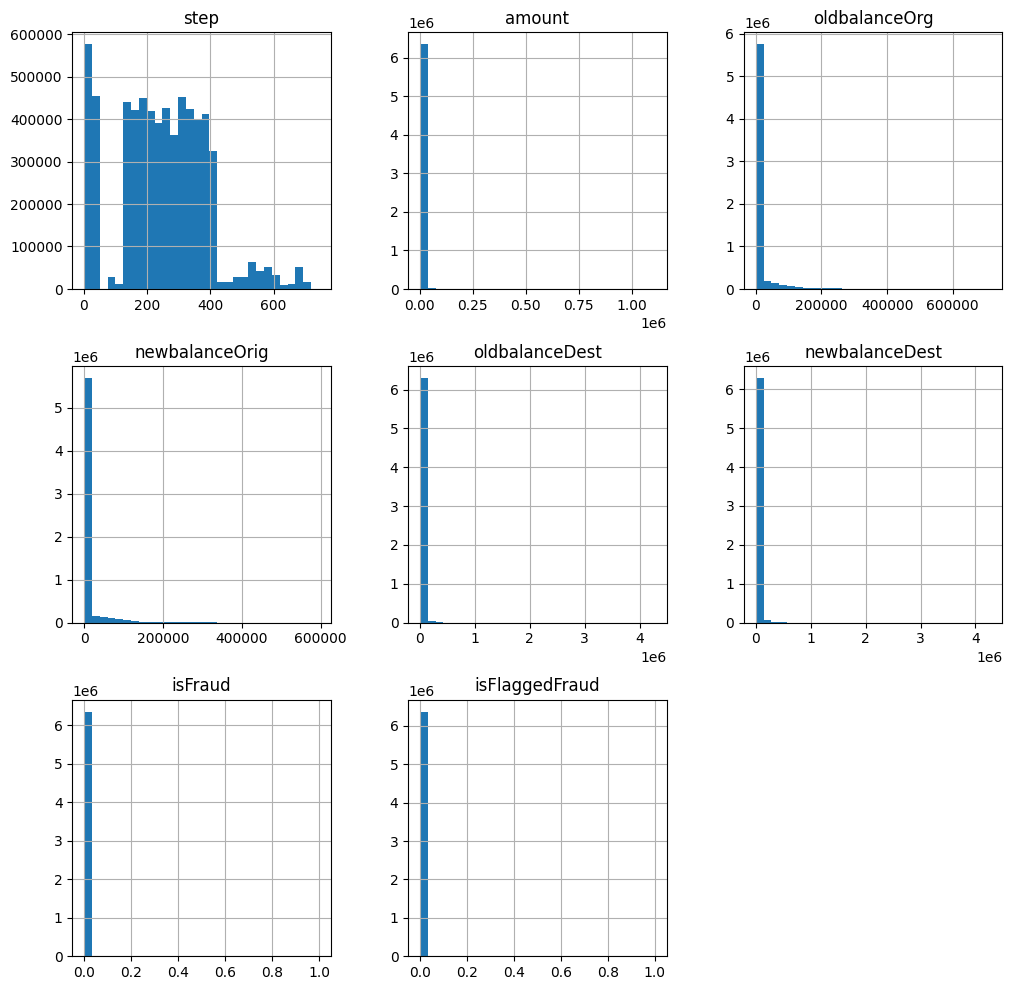

In [8]:
df[num_cols].hist(figsize=(12,12),bins=30)
plt.show()

In [9]:
notFraud = len(df[df['isFraud'] == 0])
fraud = len(df[df['isFraud'] == 1])
flagFraud = len(df[df['isFlaggedFraud'] == 1])

notFraud_percent = (notFraud / (fraud + notFraud)) * 100
fraud_percent = (fraud / (fraud + notFraud)) * 100

print("Number of Legitimate transactions: ", notFraud)
print("Number of Fraud transactions: ", fraud)
print("Number of Fraud transactions flagged: ", flagFraud)
print("Percentage of Legit transactions: {:.4f} %".format(notFraud_percent))
print("Percentage of Fraud transactions: {:.3f} %".format(fraud_percent))

Number of Legitimate transactions:  6354407
Number of Fraud transactions:  8213
Number of Fraud transactions flagged:  16
Percentage of Legit transactions: 99.8709 %
Percentage of Fraud transactions: 0.129 %


* Data highly imbalanced (<.2%)
* Rule-based system Obsolete

#### Exploring transaction type 

<Axes: xlabel='type', ylabel='count'>

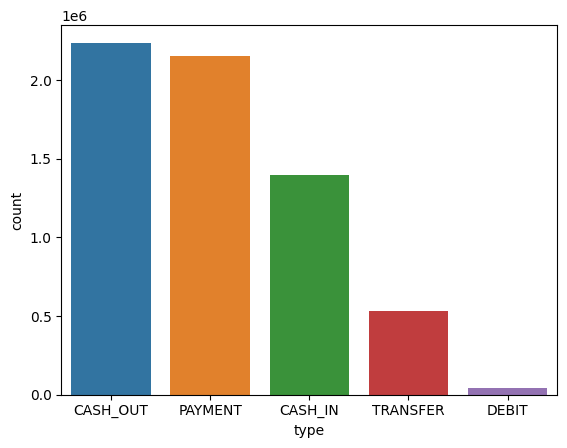

In [10]:
sns.countplot(x='type',data=df,order=df['type'].value_counts().index)

In [11]:
print(df[df['isFraud']==1].groupby('type')['isFraud'].count())

type
CASH_OUT    4116
TRANSFER    4097
Name: isFraud, dtype: int64


Fraud happened in only 2 types of transactions

#### Exploring Outliers

In [12]:
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[col][(df[col] > upper_bound) | (df[col] < lower_bound)]
    
    print(f'{col}:{len(outliers)}')

step:102688
amount:338078
oldbalanceOrg:1112507
newbalanceOrig:1053391
oldbalanceDest:786135
newbalanceDest:738527
isFraud:8213
isFlaggedFraud:16


A lot of outliers present. Approaches:
* Drop outliers
* Scale using robust scaling

In [13]:
def drop_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[col][(df[col] > upper_bound) | (df[col] < lower_bound)]
        df = df.drop(outliers.index)
        
    return df

df_dropped = df.copy()
df_dropped = drop_outliers(df_dropped, num_cols)
    
print(f'No. of rows in dropped: {df_dropped.shape[0]} \n')
print(f'Percentage data dropped: {(df_dropped.shape[0] / df.shape[0]) * 100} \n')
print('class makeup:\n', df_dropped['isFraud'].value_counts())

No. of rows in dropped: 3196840 

Percentage data dropped: 50.24408184049967 

class makeup:
 isFraud
0    3196840
Name: count, dtype: int64


Dropping outliers removes all Fraud transactions, approach cannot be continued.

In [14]:
# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the categorical column
encoded_data = encoder.fit_transform(df[['type']])

# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['type']))

# Concatenate the original DataFrame with the encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)

In [15]:
# Function to calculate VIF
def calc_vif(df):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

# Dropping unneeded categorical columns
df.drop(['type', 'nameOrig', 'nameDest'], axis=1, inplace=True)

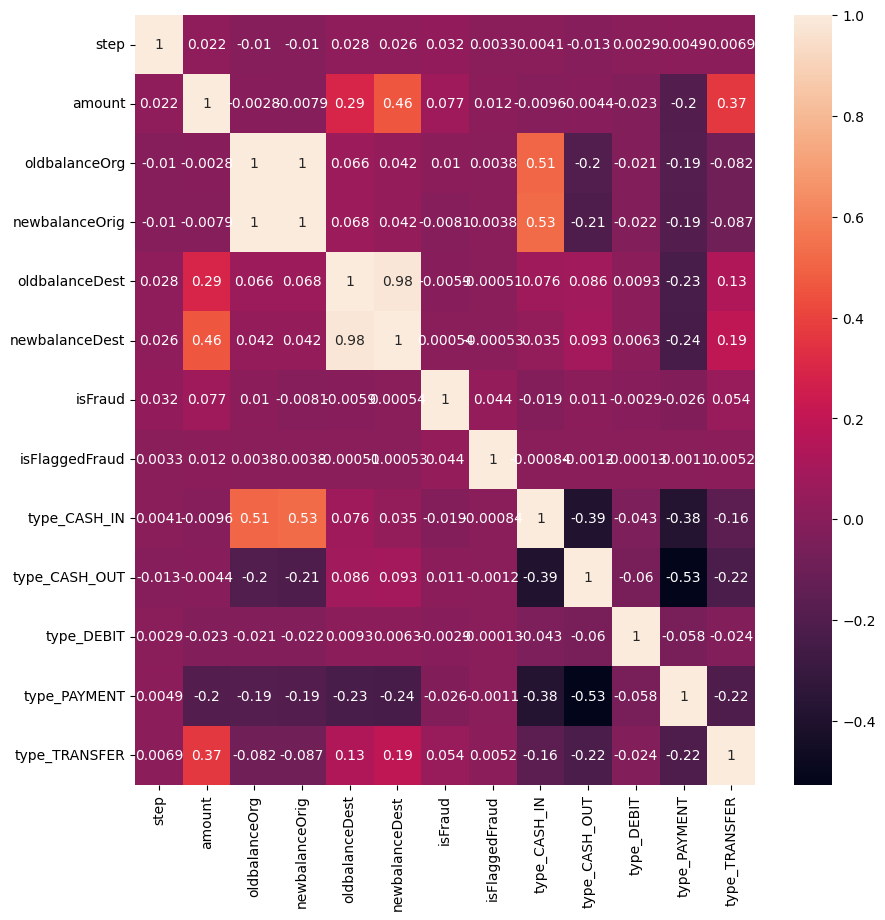

,variables,VIF
0,step,1.003449
1,amount,4.075424
2,oldbalanceOrg,669.074960
3,newbalanceOrig,688.656352
4,oldbalanceDest,68.603157
5,newbalanceDest,79.000140
6,isFraud,1.226090
7,isFlaggedFraud,1.002819
8,type_CASH_IN,2.818880
9,type_CASH_OUT,2.096413


In [16]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(method='pearson'), ax=ax, annot=True)
plt.show()

calc_vif(df)

* High MultiCollinearity present in 4 columns

## Data Preparation

#### Removing problematic columns

In [17]:
df1 = df.drop(['newbalanceOrig', 'oldbalanceDest', 'isFlaggedFraud'], axis=1)

calc_vif(df1)

,variables,VIF
0,step,1.002297
1,amount,1.422583
2,oldbalanceOrg,1.348050
3,newbalanceDest,1.310005
4,isFraud,1.010477
5,type_CASH_IN,2.151254
6,type_CASH_OUT,2.078252
7,type_DEBIT,1.021082
8,type_PAYMENT,1.999810
9,type_TRANSFER,1.474931


#### Scaling Numerical columns

In [18]:
#update num_cols
for col in ['newbalanceOrig', 'oldbalanceDest', 'isFlaggedFraud']:
    if col in num_cols:
        num_cols.remove(col)

# Initialize RobustScaler
scaler = RobustScaler()

# Fit, transform, and scale the data
scaled_data = scaler.fit_transform(df1)
scaled_df = pd.DataFrame(scaled_data, columns=df1.columns)
scaled_df.describe()

,step,amount,oldbalanceOrg,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.456562e-02,5.374952e-01,7.638017e+00,9.086488e-01,1.290820e-03,2.199226e-01,3.516633e-01,6.511783e-03,3.381461e-01,8.375622e-02
std,7.951507e-01,3.091447e+00,2.691365e+01,3.304342e+00,3.590480e-02,4.141940e-01,4.774895e-01,8.043246e-02,4.730786e-01,2.770219e-01
min,-1.329609e+00,-3.833062e-01,-1.323951e-01,-1.930566e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-4.636872e-01,-3.147585e-01,-1.323951e-01,-1.930566e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.363128e-01,6.852415e-01,8.676049e-01,8.069434e-01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,2.815642e+00,4.728907e+02,5.551017e+02,3.201382e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


#### Handling data imbalance

In [19]:
# Sampling for splits
new_df = scaled_df.sample(frac = 1, random_state = 2)

# Splitting into train/test/valid
train, test, valid = new_df[:5090096], new_df[5090096:5726358], new_df[5726358:]
train['isFraud'].value_counts(), test['isFraud'].value_counts(), valid['isFraud'].value_counts()

# Creating sample training set
train_us = train.copy()

# Creating sample objects
rus = RandomUnderSampler(sampling_strategy='majority')

In [20]:
# Preparing sampled sets
x_train_us, y_train_us = rus.fit_resample(train_us.drop('isFraud', axis=1), train_us['isFraud'])

# Formatting response values
y_train_us = y_train_us.values

# Preparing test and validation sets
x_train, y_train = train.drop('isFraud', axis = 1), train['isFraud']
x_test, y_test = test.drop('isFraud', axis = 1), test['isFraud']
x_valid, y_valid = valid.drop('isFraud', axis = 1), valid['isFraud']

Approaches for imbalance:
* Undersampled data
* Oversampled data - Will overfit as 5 million rows are to be samplped
* SMOTE data - Will overfit as 5 million rows are to be samplped
* data

## Model Fitting

Fitting the models on all training sets to identify best approach.

In [21]:
# Creating function for making confusion matrices
def cm_gen(cm):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

### Random Forest Classifier

In [22]:
rf = RandomForestClassifier()

# Defining parameters
params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth':[None, 5, 10, 20],
}

# Define scoring metrics
scores = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1_score': make_scorer(f1_score)
}

# Creating GridSearchCV object
grid_search = GridSearchCV(estimator = rf, param_grid = params, cv=5, scoring = scores, refit = 'f1_score')

### Undersampled data

In [23]:
# Fit the data to perform the grid search
grid_search.fit(x_train_us, y_train_us)

# Get the best parameter(s) and score for the best performing metric
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best number of trees (n_estimators, max_depth): {(best_params['n_estimators'], best_params['max_depth'])}")
print(f"Best F1 score: {best_score}")

Best number of trees (n_estimators, max_depth): (200, None)
Best F1 score: 0.9870263647431805


              precision    recall  f1-score   support

       Legit       1.00      0.98      0.99    635455
       Fraud       0.06      0.99      0.10       807

    accuracy                           0.98    636262
   macro avg       0.53      0.98      0.55    636262
weighted avg       1.00      0.98      0.99    636262



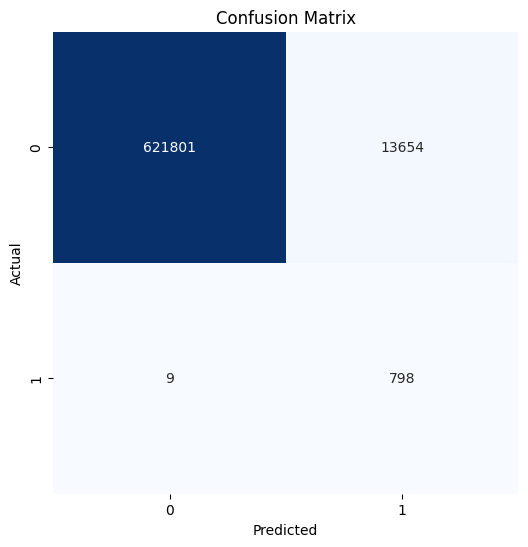

In [24]:
# Creating RF Classifier with best params
rf_us = RandomForestClassifier(n_estimators = 50, max_depth = 20, random_state = 2)
rf_us.fit(x_train_us, y_train_us)
y_pred_us = rf_us.predict(x_test)
cm_us = confusion_matrix(y_test, y_pred_us)

print(classification_report(y_test, y_pred_us, target_names = ['Legit', 'Fraud']))
cm_gen(cm_us)

In [25]:
y_preds = rf_us.predict_proba(x_test)[:, 1]

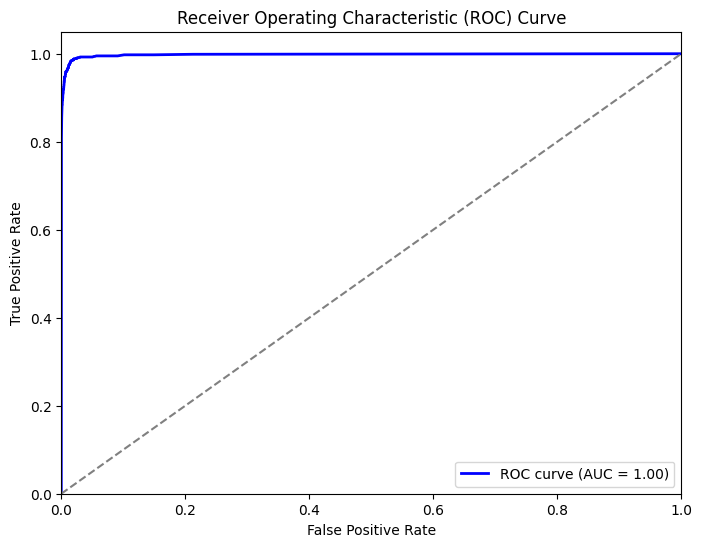

In [26]:
# Calculating ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

AUC at threshold 0.2: 0.9699403232783949



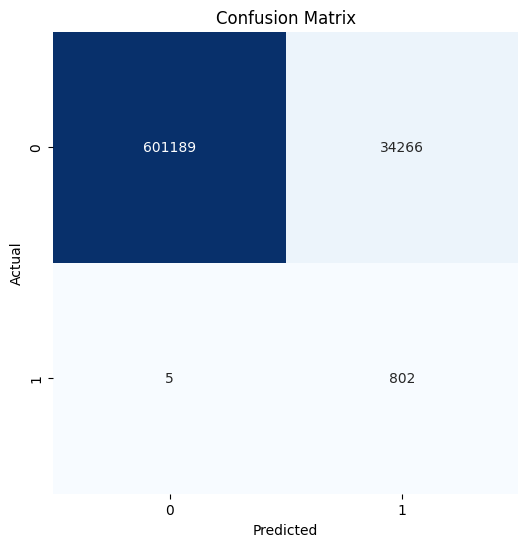

AUC at threshold 0.3: 0.97656673368633



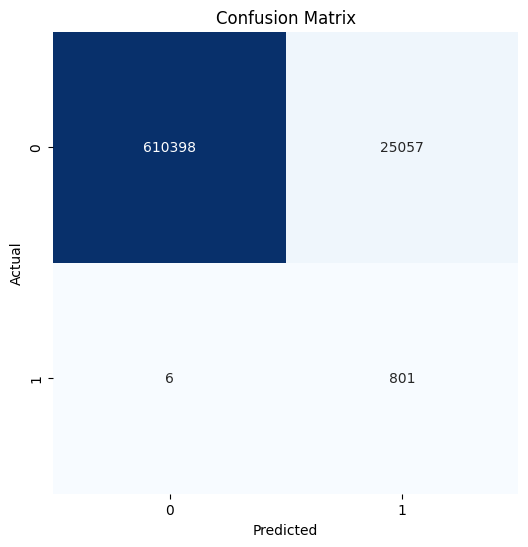

AUC at threshold 0.4: 0.9808924304324009



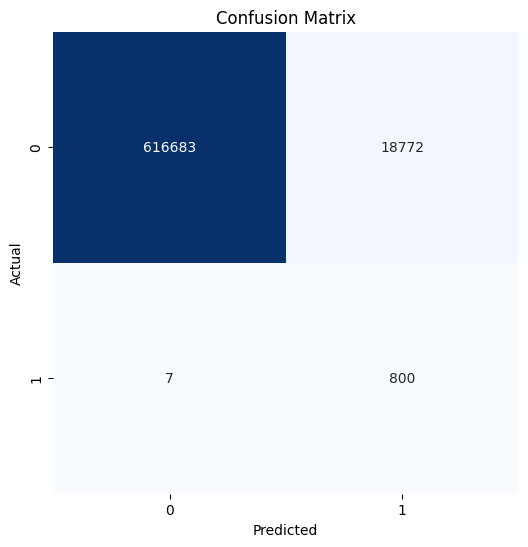

AUC at threshold 0.5: 0.9836803088054547



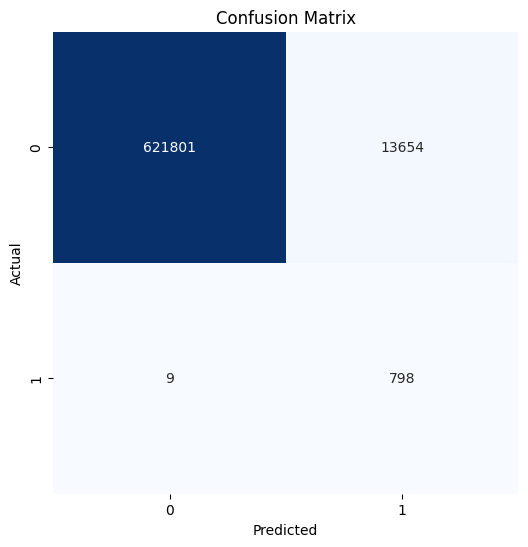

AUC at threshold 0.6: 0.9831668401171085



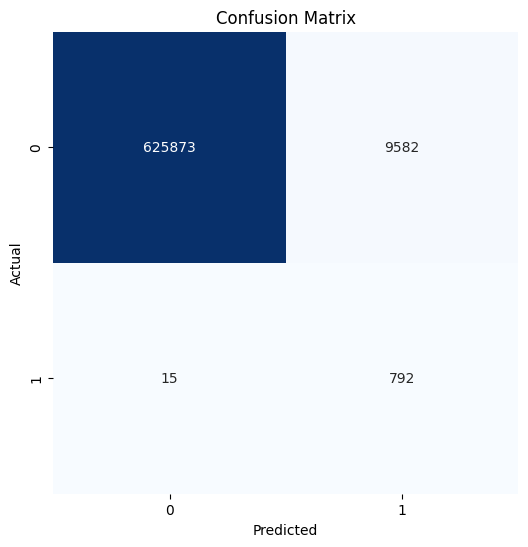

AUC at threshold 0.7: 0.9767160047103796



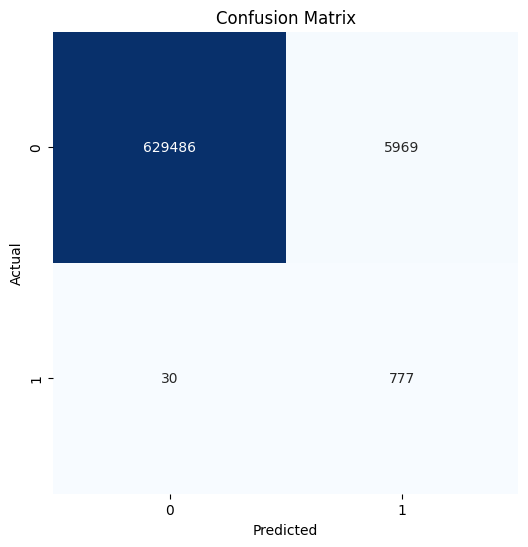

AUC at threshold 0.75: 0.9754384044131088



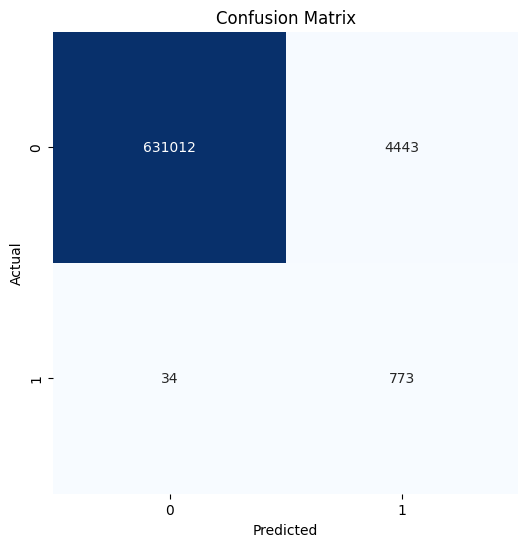

AUC at threshold 0.8: 0.9666456024245991



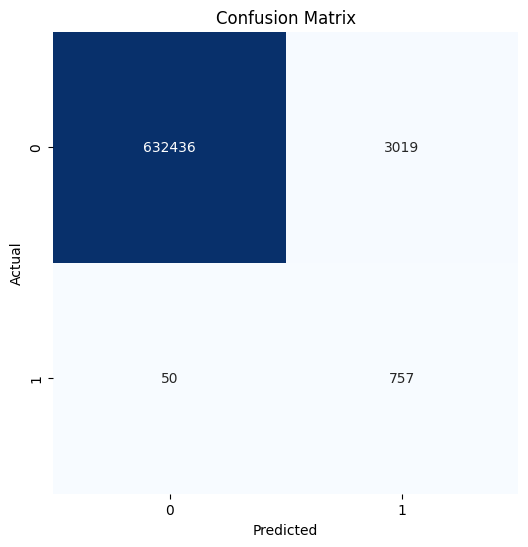

AUC at threshold 0.85: 0.9544897426725537



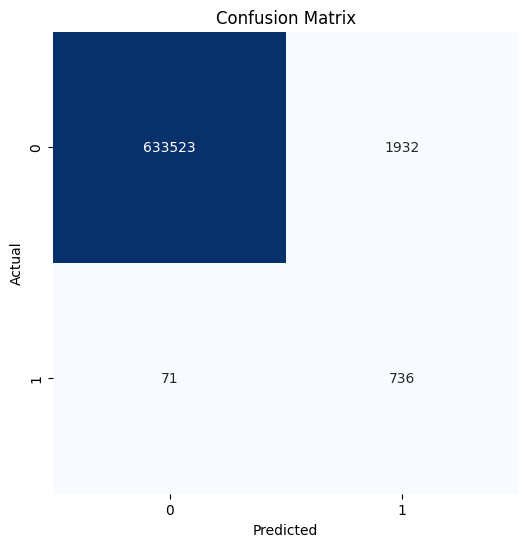

AUC at threshold 0.866: 0.9522702975554295



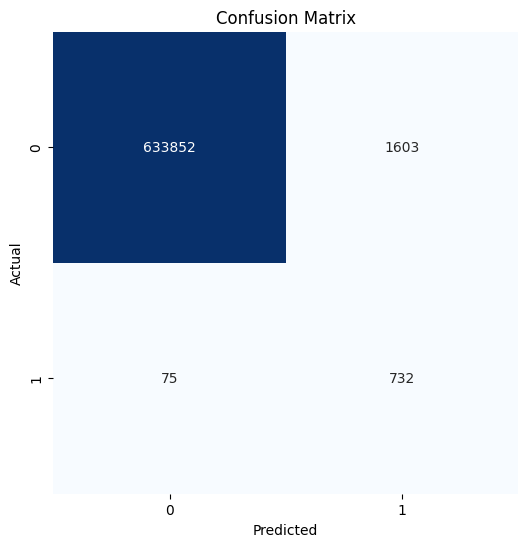

AUC at threshold 0.9: 0.9416214573762517



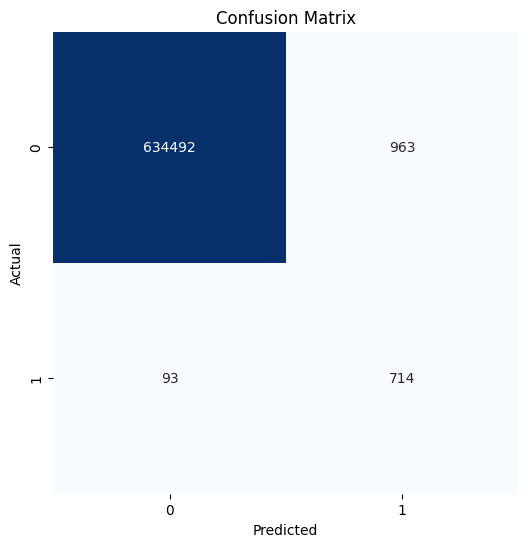

In [27]:
for i, threshold in enumerate([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.866, 0.9]):
    y_pred_threshold = (y_preds > threshold).astype(int)
    fpr, tpr, _ = roc_curve(y_test, y_pred_threshold)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(y_test, y_pred_threshold)
    print(f"AUC at threshold {threshold}: {roc_auc}\n") #+ f"False +ive: {fpr}\t True +ive: {tpr}\n\n")
    cm_gen(cm)

AUC at threshold 0.7: 0.9824985108316394

              precision    recall  f1-score   support

       Legit       1.00      0.99      1.00    635436
       Fraud       0.12      0.97      0.21       826

    accuracy                           0.99    636262
   macro avg       0.56      0.98      0.60    636262
weighted avg       1.00      0.99      0.99    636262



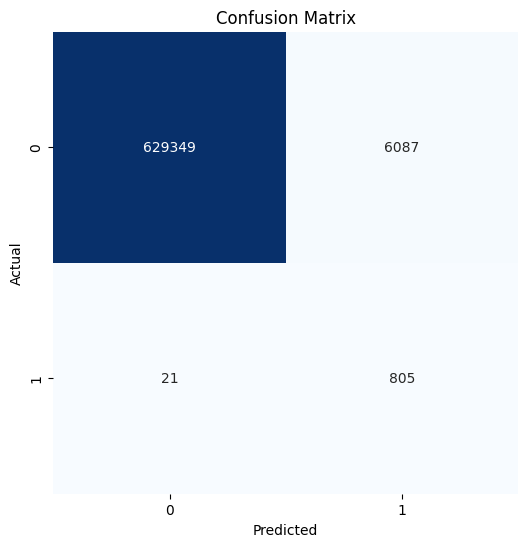

AUC at threshold 0.75: 0.9763873401248342

              precision    recall  f1-score   support

       Legit       1.00      0.99      1.00    635436
       Fraud       0.15      0.96      0.25       826

    accuracy                           0.99    636262
   macro avg       0.57      0.98      0.63    636262
weighted avg       1.00      0.99      1.00    636262



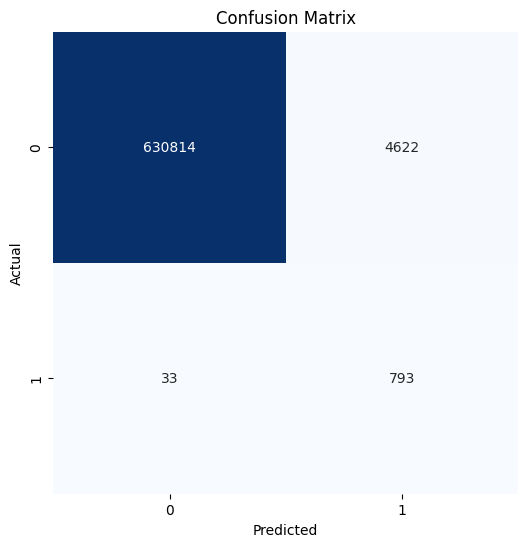

AUC at threshold 0.8: 0.9678281086276168

              precision    recall  f1-score   support

       Legit       1.00      0.99      1.00    635436
       Fraud       0.20      0.94      0.32       826

    accuracy                           0.99    636262
   macro avg       0.60      0.97      0.66    636262
weighted avg       1.00      0.99      1.00    636262



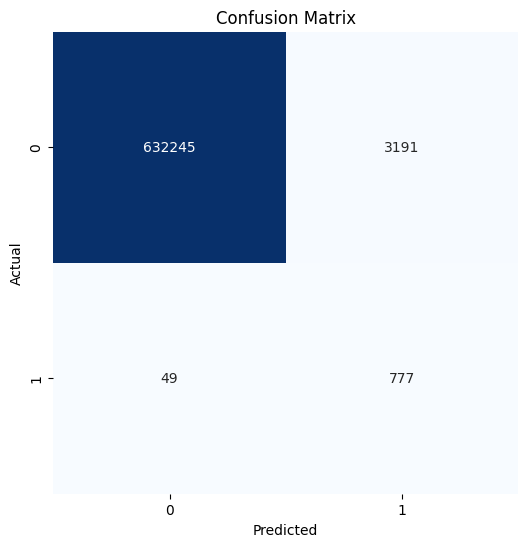

AUC at threshold 0.85: 0.9620917144350541

              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00    635436
       Fraud       0.28      0.93      0.42       826

    accuracy                           1.00    636262
   macro avg       0.64      0.96      0.71    636262
weighted avg       1.00      1.00      1.00    636262



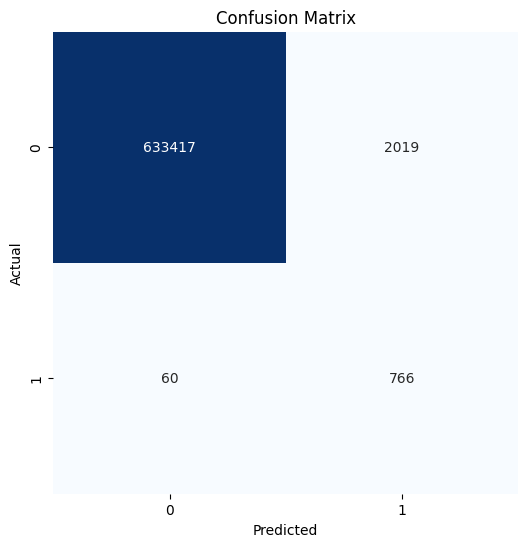

AUC at threshold 0.866: 0.9575213534343666

              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00    635436
       Fraud       0.31      0.92      0.47       826

    accuracy                           1.00    636262
   macro avg       0.66      0.96      0.73    636262
weighted avg       1.00      1.00      1.00    636262



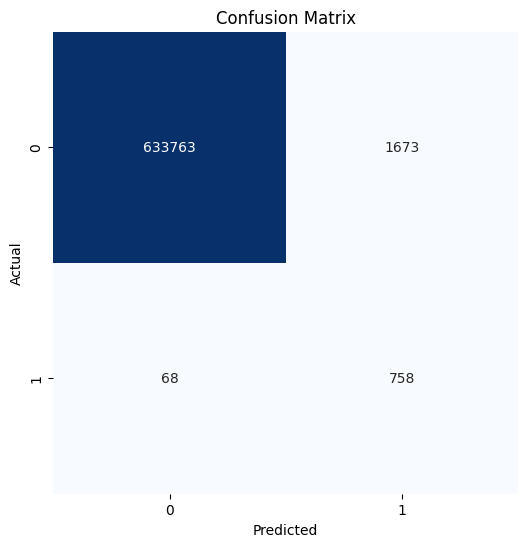

AUC at threshold 0.9: 0.9459286363360555

              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00    635436
       Fraud       0.42      0.89      0.57       826

    accuracy                           1.00    636262
   macro avg       0.71      0.95      0.79    636262
weighted avg       1.00      1.00      1.00    636262



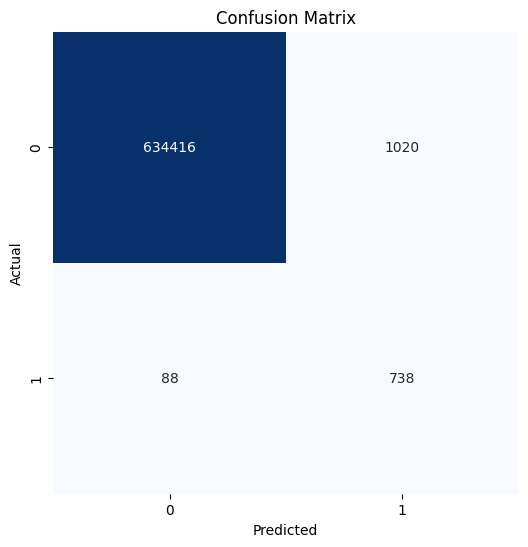

In [28]:
y_pred_v = rf_us.predict_proba(x_valid)[:, 1]

for i, threshold in enumerate([0.7, 0.75, 0.8, 0.85, 0.866, 0.9]):
    y_pred_thres = (y_pred_v > threshold).astype(int)
    fpr, tpr, _ = roc_curve(y_valid, y_pred_thres)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(y_valid, y_pred_thres)
    print(f"AUC at threshold {threshold}: {roc_auc}\n") #+ f"False +ive: {fpr}\t True +ive: {tpr}\n\n")
    print(classification_report(y_valid, y_pred_thres, target_names = ['Legit', 'Fraud']))
    cm_gen(cm)

In [29]:
df2 = data.copy()

In [30]:
df2['nameOrig'] = df2['nameOrig'].str[0]